# Single AI crypto concept

In [1]:
from xdata_config import *

WINDOW:35 - BUY_PCT:1.8 MAX_FORCAST_SIZE:35 - BUY_MODE:IS_CLOSE 


## 1 - Imports and fonctions

In [2]:
from functions_module import *

2023-04-10 14:18:43.964407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-10 14:18:43.964467: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-10 14:18:44.056368: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-10 14:18:46.070317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-10 14:18:46.070775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense 
from keras.models import load_model
from keras.layers import BatchNormalization, Dense

In [ ]:
def buy_optimal_5m(df,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=MAX_FORCAST_SIZE):
    #df = df.fillna(0)
    mino = BUY_PCT / 100.0
    maxo = SELL_PCT / 100.0
    window=max(7,int(window/5))
    max_forecast_size=window#MAX_FORCAST_SIZE
    try:
        after_dip_val=AFTER_MARK
    except:
        after_dip_val=3
    print(f"after mark = : {after_dip_val}")
    try:
        print(f"optimalbuy buy maximum forcast size={max_forecast_size} at {BUY_PCT}% of the current price ")
    except:
        max_forecast_size = 3
        print("optimalbuy buy default window=3")
        
    rolling_max_close_diff = ((df['close-1_5min'].rolling(window=window).max().shift(-window+1) / df['close']) - 1).fillna(0)
    df['buy']=(rolling_max_close_diff >= mino).astype(int)
    
    # Compute rolling minimum values
    window_list=[window]#[3, 5, 7, 10, 15, 20]
    
    for window_size in window_list:
        col_name = f'ismin{window_size}'
        rolling_min = (df['close'].shift(after_dip_val) <= df.shift(-window_size-1)['close-1_5min'].rolling(2*window_size).min())
        df = df.assign(**{col_name: rolling_min.astype(int)})

    df['ismin'] = df[[f'ismin{window_size}' for window_size in window_list ]].any(axis=1).astype(int)        

    # # Compute buy and sell signals
    rolling_low_close_diff =  ((df['low-1_5min'].rolling(window=int(window/2)).min().shift(-int(window/2)+1)/ df['close'] ) -1).fillna(0)
    df['sell'] = (rolling_low_close_diff <= -maxo).astype(int)

    
    # Compute final buy signal
    df['buy'] = ((df['buy'] == 1) & (df['sell'] == 0) & (df['ismin'] == 1)).astype(int)
    # Remove unnecessary columns
    df = df.drop(columns=['sell', 'ismin'] + [f'ismin{window_size}' for window_size in window_list], errors='ignore')
    return df



def full_expand_costum(df1m,df5m,df15m,df1h,df1d,w1m=10,w5m=30,w15m=30,w1h=3,w1d=7):
    d1min=df1m.copy()
    d1min=expand_previous(d1min,window=w1m).drop(columns=["volume"])
    d1min=rapid1d_expand(d1min,df1d,w1d)
    d1min=rapid1h_expand(d1min,df1h,w1h)
    d1min=rapid15m_expand(d1min,df15m,w15m)
    d1min=rapid5m_expand(d1min,df5m,w5m)
    return d1min

def maxi_expand(pair="GMT/USDT", i=0, j=10000, window=2, metadata=MetaData,
                 high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                 buy_function=buy_alwase,w1m=6,w5m=30,w15m=30,w1h=3,w1d=7,btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=30,btc_w1d=30):
    start_index=i
    end_index=j
    window_size=window
    buy_fn=buy_function
    """
    This function takes in several parameters to calculate technical indicators and returns a merged dataframe.
    
    :param pair: str, default "GMT/USDT"
        The trading pair to analyze.
        
    :param start_index: int, default 0
        The start index for selecting data.
        
    :param end_index: int, default 10000
        The end index for selecting data.
    
    :param window_size: int, default 2
        The window size to use for analyzing the data.
    
    :param metadata: MetaData
        The metadata to use for analyzing the data.
    
    :param high_weight: int, default 1
        The weight to use for calculating the high.
    
    :param BUY_PCT: float, default BUY_PCT
        The buy pct to use for analyzing the data.
    
    :param SELL_PCT: float, default SELL_PCT
        The sell pct to use for analyzing the data.
    
    :param buy_fn: function, default buy_min_up
        The buy function to use for analyzing the data.
    
    :return: pd.DataFrame
        A merged dataframe containing the calculated technical indicators.
    """
    print(f"maxi custum expend : {pair} with those parameters: w1m={w1m},w5m={w5m},w15m={w15m},w1h={w1h},w1d={w1d} btc_w1m={btc_w1m},btc_w5m={btc_w5m},btc_w15m={btc_w15m},btc_w1h={btc_w1h},btc_w1d={btc_w1d}")
    # Select data
    pair_df = df_list1m[pair].iloc[start_index:end_index]
    btc_df = df_list1m["BTC/USDT"].loc[(pair_df.index[0] - pd.DateOffset(days=window_size+1)).round(freq='1 min'):pair_df.index[-1]+pd.Timedelta(f"{window_size} day")]
    # Calculate technical indicators
    pair_full = full_expand_costum(pair_df, df_list5m[pair], df_list15m[pair], df_list1h[pair], df_list1d[pair],w1m=w1m,w5m=w5m,w15m=w15m,w1h=w1h,w1d=w1d)
    btc_full = full_expand_costum(btc_df, df_list5m["BTC/USDT"], df_list15m["BTC/USDT"], df_list1h["BTC/USDT"], df_list1d["BTC/USDT"], w1m=btc_w1m,w5m=btc_w5m,w15m=btc_w15m,w1h=btc_w1h,w1d=btc_w1d)   
    btc_full = btc_full.add_prefix("BTC_")
    merged = pd.merge(pair_full, btc_full, left_index=True, right_index=True)
    day_expand(merged)
    Meta_expand(merged, metadata, pair)
    print(merged.columns)
    merged = buy_fn(merged, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=MAX_FORCAST_SIZE)
    merged["high"] = (merged["open"] + high_weight * merged["high"] + merged["low"] + merged["close"]) / (3 + high_weight)
    merged["BTC_high"] = (merged["BTC_open"] + high_weight * merged["BTC_high"] + merged["BTC_low"] + merged["BTC_close"]) / (3 + high_weight)
    merged.rename(columns={"high":"price"},inplace=True)
    merged.rename(columns={"BTC_high":"BTC_price"},inplace=True)
    merged = merged.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"])
    open_high_low_close_cols = merged.columns.str.contains("open|high|low|close")
    # merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")] = (
    #     (merged["BTC_price"] - merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")]) / merged["BTC_price"]
    # )
    # merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")] = (
    #     (merged["price"] - merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")]) / merged["price"]
    # )
    for key in merged.keys():
        if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["BTC_price"]-merged[key])/merged["BTC_price"]
        if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["price"]-merged[key])/merged["price"]

    merged=merged.dropna()
    print(f'######################  max expend {pair} - shape {merged.shape}  buy mean : {hp(merged.buy.mean())} ############################')
    return merged


In [ ]:
def buy_optimal(df,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=3):
    #df = df.fillna(0)
    mino = BUY_PCT / 100.0
    maxo = SELL_PCT / 100.0
    window=15
    max_forecast_size=15#MAX_FORCAST_SIZE
    try:
        after_dip_val=1
    except:
        after_dip_val=1
    print(f"after mark = : {after_dip_val}")
    try:
        print(f"optimalbuy buy maximum forcast size={max_forecast_size} at {BUY_PCT}% of the current price ")
    except:
        max_forecast_size = 3
        print("optimalbuy buy default window=3")
        
    rolling_max_close_diff = ((df['close'].rolling(window=window).max().shift(-window+1) / df['close']) - 1).fillna(0)
    df['buy']=(rolling_max_close_diff >= mino).astype(int)
    
    # Compute rolling minimum values
    
    window_list=[5,window]#[3, 5, 7, 10, 15, 20]
    
    for window_size in window_list:
        col_name = f'ismin{window_size}'
        rolling_min = (df['close'].shift(after_dip_val) <= df.shift(-window_size-1)['close'].rolling(2*window_size).min())
        df = df.assign(**{col_name: rolling_min.astype(int)})

    df['ismin'] = df[[f'ismin{window_size}' for window_size in window_list ]].any(axis=1).astype(int)        

    # # Compute buy and sell signals
    rolling_low_close_diff =  ((df['low'].rolling(window=int(window/2)).min().shift(-int(window/2)+1)/ df['close'] ) -1).fillna(0)
    df['sell'] = (rolling_low_close_diff <= -maxo).astype(int)

    
    # Compute final buy signal
    df['buy'] = ((df['buy'] == 1) & (df['sell'] == 0) & (df['ismin'] == 1)).astype(int)
    # Remove unnecessary columns
    df = df.drop(columns=['sell', 'ismin'] + [f'ismin{window_size}' for window_size in window_list], errors='ignore')
    return df
def plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, window_size, PREDICTION_TO_TEST,dot_color="g"):
    i_end=i_start+window_size
    mname = Model_FileName.replace("/UltimeTradingBot/Data","")
    coin = pair_to_test.replace('/', '-')
    mtitle = f"{coin} WinRatio:{hp(winratio)}% - {mname}".replace("/", "-")
    
    # Set the background color of the plot to white
    plt.rcParams['axes.facecolor'] = 'black'
 
    # Plot all the prices
    plt.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], label='Price',c="w")

    # Overlay the 'buy' dots on the plot
    plt.scatter(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, color=dot_color, marker='o', label='Buy')

    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.title(mtitle)
    plt.legend()

    plt.show()


In [ ]:
def is_local_min(df, BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating local minimum.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min

    return df


def is_near_min_v1(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5, num_values=3):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a local minimum
    or near the local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.
    num_values (int): The number of values near the local minimum to include.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating local minimum and its neighbors.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum or near the local minimum
    close_diff = np.abs(df['close'] - rolling_min_close)
    threshold = close_diff.nsmallest(num_values+1).iloc[-1]
    local_min = (close_diff <= threshold).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min

    return df

import numpy as np

def is_near_min(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5, num_values=3):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a local minimum
    or within the specified range before or after the local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.
    num_values (int): The number of values before and after the local minimum to include.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating local minimum and its neighbors.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min

    # Include values before and after the local minimum
    for i in range(1, num_values+1):
        df['buy'] = df['buy'] | df['buy'].shift(-i) | df['buy'].shift(i)

    # Fill any NaN values introduced by shifting with 0
    df['buy'].fillna(0, inplace=True)

    return df


def is_max_win(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a winning trade.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    BUY_PCT (float): Minimum percentage change required for a trade to be profitable.
    window (int): The window size for computing maximum price change.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating winning trades.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=7, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close)

    # Compute maximum price change over next `window` rows
    # max_price = df['close'].rolling(window=window, min_periods=1).max()
    # max_price_shifted = max_price.shift(-window)
    # max_price_change = ((max_price_shifted - max_price)/max_price).fillna(0)
    max_price = df['close'].shift(periods=-window+1).rolling(window=window, min_periods=1).max()#.pct_change(window=window-1)

    # Check if the maximum price change is greater than the BUY_PCT threshold
    win = (max_price >= (BUY_PCT/100+1)*df['close'])

    # Combine local minimum and winning trade conditions
    df['buy'] = (local_min & win).astype(int)

    return df

def is_close_win(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a winning trade.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    BUY_PCT (float): Minimum percentage change required for a trade to be profitable.
    window (int): The window size for computing maximum price change.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating winning trades.
    """

    max_price = df['close'].shift(periods=-window+1).rolling(window=window, min_periods=1).max()#.pct_change(window=window-1)

    # Check if the maximum price change is greater than the BUY_PCT threshold
    win = (max_price >= (BUY_PCT/100+1)*df['close'])

    # Combine local minimum and winning trade conditions
    df['buy'] = (win).astype(int)

    return df

def is_high_win(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a winning trade.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    BUY_PCT (float): Minimum percentage change required for a trade to be profitable.
    window (int): The window size for computing maximum price change.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating winning trades.
    """
    max_price = df['high'].shift(periods=-window+1).rolling(window=window, min_periods=1).max()#.pct_change(window=window-1)

    # Check if the maximum price change is greater than the BUY_PCT threshold
    win = (max_price >= (BUY_PCT/100+1)*df['close'])

    # Combine local minimum and winning trade conditions
    df['buy'] = (win).astype(int)

    return df


In [ ]:
## Test
pair="SNM/BUSD"
#df=maxi_expand(pair=pair,i=0,j=len(df_list1m[pair]),window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=0.6,SELL_PCT=0.3,buy_function=buy_only)
df=mini_expand5(pair=pair,i=0,j=len(df_list1m[pair]),window=2,metadata=MetaData,BUY_PCT=1.7,SELL_PCT=0.3,buy_function=is_local_min)
#df = full_expand_costum(df_list1m[pair], df_list5m[pair], df_list15m[pair], df_list1h[pair], df_list1d[pair],w1m=6,w5m=30,w15m=30,w1h=3,w1d=7)
plot_data("test big opt", pair, 0, df, 1000, 60,df.buy,dot_color="g")



In [ ]:
df=maxi_expand(pair=pair,i=0,j=len(df_list1m[pair]),window=2,metadata=MetaData,BUY_PCT=1.7,SELL_PCT=0.3,buy_function=is_local_min)


## Special list if needed

In [ ]:
Binance_USDT_HALAL.index("ROSE/USDT")

In [ ]:
# from datetime import date
# TICKERS = "../Binance-Fast-Trade-Bot/volatile_volume_" + str(date.today()) + ".txt"
# VOLATILE_COINS=[line.strip() for line in open(TICKERS)]
# PAIR_WITH="USDT"
# VOLATILE_USDT_PAIRS=[coin+"/USDT" for coin in VOLATILE_COINS]
# VOLATILE_BUSD_PAIRS=[coin+"/BUSD" for coin in VOLATILE_COINS]
# VOLATILE_USDT_PAIRS

# coins_to_download=''
# for coin in VOLATILE_COINS:
#     coins_to_download=coins_to_download+" "+coin
# f"node database/ddargs.js {coins_to_download} {PAIR_WITH}"

In [ ]:
# coins_to_download=''
# for coin in VOLATILE_COINS:
#     coins_to_download=coins_to_download+" "+coin
# os.system(f"node database/ddargs.js {coins_to_download} {PAIR_WITH}")#node database/ddargs.js ORN BUSD

In [ ]:
# pair_list = find_intersection(VOLATILE_USDT_PAIRS,Binance_USDT_HALAL)
# #tf = '1m'
# oldest_pair = "BTC/USDT"
# if oldest_pair not in pair_list: pair_list.append(oldest_pair)
# df_list1m = {}
# df_list1d = {}
# df_list1h = {}
# df_list5m = {}
# df_list15m = {}


# for pair in pair_list:
#     df = get_historical_from_db(ccxt.binance(), pair, '1m', path="./database/")
#     df_list1m[pair] = df.loc[:]

# for pair in pair_list:
#     df = get_historical_from_db(ccxt.binance(), pair, '1d', path="./database/")
#     df_list1d[pair] = df.loc[:]

# for pair in pair_list:
#     df = get_historical_from_db(ccxt.binance(), pair, '1h', path="./database/")
#     df_list1h[pair] = df.loc[:]

# for pair in pair_list:
#     df = get_historical_from_db(ccxt.binance(), pair, '5m', path="./database/")
#     df_list5m[pair] = df.loc[:]

# for pair in pair_list:
#     df = get_historical_from_db(
#         ccxt.binance(), pair, '15m', path="./database/")
#     df_list15m[pair] = df.loc[:]
# del(df)
# df_list = df_list1m
# prerr("Data load 100% use df_list1d[\"BTC/USDT\"] for exemple to access")



## Checking the import

In [ ]:
# chking import
MetaData

In [ ]:
if BUY_MODE=="BUY_ONLY":
    buy_function=buy_up_only
elif BUY_MODE=="BUY_UP":
    buy_function=buy_up
elif  BUY_MODE=="BUY_DIP":
    buy_function=buy_min_up
elif  BUY_MODE=="AFTER_DEPTH":
    buy_function=buy_after_depth
elif  BUY_MODE=="BUY_UP_CLOSE":
    buy_function=buy_up_close
elif  BUY_MODE=="AFTER_DEPTH_CLOSE":
    buy_function=buy_after_depth_close
elif  BUY_MODE=="BUY_TEST":
    buy_function=buy_test
elif BUY_MODE=="BUY_MIN_CLOSE":
    buy_function=buy_min_close
elif  BUY_MODE=="SELL_TEST":
    buy_function=sell_test
elif  BUY_MODE=="BUY_FIX":
    buy_function=buy_fix
elif  BUY_MODE=="BUY_OPTIMAL":
    buy_function=buy_optimal
elif  BUY_MODE=="IS_MIN":
    buy_function=is_local_min
elif  BUY_MODE=="IS_HIGH":
    buy_function=is_high_win
elif  BUY_MODE=="IS_CLOSE":
    buy_function=is_close_win
try:
    os.mkdir(DATA_DIR, mode = 0o777)
except Exception as e:
    print(e)
print(f"Results dir: {DATA_DIR}")



In [ ]:
xdf=pd.DataFrame()
count=0
row_numbers=10000
for pair in pair_list[:]:
    if pair != "BTC/USDT" and pair != "EUR/USDT" and pair != "ETH/USDT" :
        print("working on: "+pair ,end=" -->")
        try:
            
            df=maxi_expand(pair=pair,i=0,j=len(df_list1m[pair]),window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,buy_function=buy_function,
                           w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)
            print("df original shape "+str(df.shape))
            print(f"df original shape buy mean : {df.buy.mean()*100}")
            df=df.reset_index()
            try:df.pop("num_index")
            except: pass
            try:df.pop("index")
            except: pass
            try:df.pop("date")
            except: pass
            df=data_shufler(df)            
            #df=data_chooser(df,weight=50,row_numbers=df.buy.sum()*2)
            df=data_chooser50(df,row_numbers=row_numbers)
            gc.collect()
            df=data_cleanup(df)
            df=df.dropna()
            print(pair+f" is processed -- {count}/{len(pair_list)}")
            # print(df.iloc[0:1])
        except Exception as e:
            print(f"error while processing {pair} {count}/{len(pair_list)}")
            print(e)
        xdf=pd.concat([xdf,df],axis=0)
        count+=1
        del(df)
        gc.collect()
df=xdf
del xdf
gc.collect()


In [ ]:
df=df.reset_index().drop(columns="num_index")
gc.collect()
for i in range(1):
    df = df.reindex(np.random.permutation(df.index)).reset_index().drop(columns="index")
    gc.collect()
df

In [ ]:
df

In [ ]:
df.to_feather(f"../BigFiles/fea/w{WINDOW_SIZE}_buy{BUY_PCT}_forcasr{MAX_FORCAST_SIZE}min_{BUY_MODE}.fea")


In [ ]:
gc.collect()
print("df choosen data shape"+str(df.shape))
print(f"pair: {(df.shape[0]/2)==df.buy.sum()}")
dt=df.to_numpy(dtype=np.float32)
#dt=df.to_numpy()
dt=np.nan_to_num(dt,nan=0)
#dt=dt.astype(np.float32)
dt=np.nan_to_num(dt, neginf=0) 
dt=np.nan_to_num(dt, posinf=0) 

index_20pct= int(0.2*len(dt[:,0]))
print(index_20pct)


In [ ]:
del df
gc.collect()

In [ ]:
# # feather loading
# df=pd.read_feather(f"../Data/fea/w{WINDOW_SIZE}_buy{BUY_PCT}_forcasr{MAX_FORCAST_SIZE}min_{BUY_MODE}.fea")
# dt=df.to_numpy(dtype=np.float32)
# dt=fixdt(dt)
# index_20pct= int(0.2*len(dt[:,0]))
# gc.collect()



## Self-Normalized Model

In [ ]:

## Normalzed Model
IN_DIM=dt.shape[1]-1
model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(int(250),activation='relu')) 
model.add(BatchNormalization())
model.add(Dense(int(20),activation='relu')) 
model.add(Dense(int(50),activation='relu')) 
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
callbacks_a = ModelCheckpoint(filepath =Model_FileName,monitor ='val_accuracy',save_best_only = True, save_weights = True)
callbacks_b = EarlyStopping(monitor ='val_accuracy',mode='auto',patience=15,verbose=1)
print("saving file in: "+Model_FileName)
history = model.fit(dt[index_20pct:, 0:-1],
                dt[index_20pct:,-1],
                validation_data=(dt[:index_20pct, :-1],dt[:index_20pct,-1]),
                epochs=6000,
                batch_size=256*10,
                callbacks=[callbacks_a,callbacks_b])

print('##########################################################################')
print(f"------val_accuracy-----> {'{0:.4g}'.format(max(history.history['val_accuracy'])*100)} | {'{0:.4g}'.format(max(history.history['accuracy'])*100)} <----------accuracy----------")
print(Normalization_File)
print(Model_FileName)
model_init_file=Model_FileName.replace(f"_v{VERSION}", "_vInit")
print(f"save to: {model_init_file}")
model.save(model_init_file)
model_init=model

In [ ]:
# model_init_file=Model_FileName.replace(f"_v{VERSION}", "_vInit")
# print(f"save to: {model_init_file}")
# model.save(model_init_file)
# model_init=model

## 2- Model Plus - Very deep

In [ ]:
import gc
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the class weights
class_weights = {0: 1., 1: 1.}

gc.collect()

SizeTunner = 1
IN_DIM = dt.shape[1] - 1

model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(int(300 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(200 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(int(20 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='val_accuracy', mode='auto', patience=6, verbose=1)
]

print("saving file in: " + Model_FileName)
history = model.fit(dt[index_20pct:, :-1],
                    dt[index_20pct:, -1],
                    validation_data=(dt[:index_20pct, :-1], dt[:index_20pct, -1]),
                    epochs=500,
                    batch_size=256*10,
                    callbacks=callbacks,
                    class_weight=class_weights)

verydeep_model_file=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5"
model.save(verydeep_model_file)
print(verydeep_model_file)
very_deep_model=load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5")
#868/868 [==============================] - 30s 35ms/step - loss: 0.6078 - accuracy: 0.6664 - val_loss: 0.6107 - val_accuracy: 0.6639 >0.6646
#Results after 380 min
# Epoch 133/500
# 347/347 [==============================] - 138s 398ms/step - loss: 0.5867 - accuracy: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.6863
# Epoch 134/500
# 347/347 [==============================] - 137s 395ms/step - loss: 0.5865 - accuracy: 0.6843 - val_loss: 0.5845 - val_accuracy: 0.6861
# Epoch 134: early stopping



In [ ]:
import gc
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the class weights
class_weights = {0: 3., 1: 1.}

gc.collect()

SizeTunner = 1
IN_DIM = dt.shape[1] - 1

model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(int(300 * SizeTunner), activation='softplus'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(200 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(int(20 * SizeTunner), activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

#optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
optimizer = Nadam(lr=0.005, beta_1=0.8, beta_2=0.99, clipnorm=1.0) #faster
#optimizer = Nadam(lr=0.0005, beta_1=0.95, beta_2=0.999, epsilon=1e-08) #optimizer more accurate

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='val_accuracy', mode='auto', patience=6, verbose=1)
]

print("saving file in: " + Model_FileName)
history = model.fit(dt[index_20pct:, :-1],
                    dt[index_20pct:, -1],
                    validation_data=(dt[:index_20pct, :-1], dt[:index_20pct, -1]),
                    epochs=500,
                    batch_size=256*10,
                    callbacks=callbacks,
                    class_weight=class_weights)

verydeep_model_file=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryBig.h5"
model.save(verydeep_model_file)
print(verydeep_model_file)
very_deep_model=load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryBig.h5")
#868/868 [==============================] - 30s 35ms/step - loss: 0.6078 - accuracy: 0.6664 - val_loss: 0.6107 - val_accuracy: 0.6639 >0.6646
#Results after 380 min
# Epoch 133/500
# 347/347 [==============================] - 138s 398ms/step - loss: 0.5867 - accuracy: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.6863
# Epoch 134/500
# 347/347 [==============================] - 137s 395ms/step - loss: 0.5865 - accuracy: 0.6843 - val_loss: 0.5845 - val_accuracy: 0.6861
# Epoch 134: early stopping



# 3 - Binary Model

In [ ]:
# import gc
# import numpy as np
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Input, Dense, Dropout, BatchNormalization
# from keras.optimizers import Nadam
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model
# from tensorflow.keras.layers.experimental.preprocessing import BinaryQuantization

# # Define the class weights
# class_weights = {0: 1., 1: 1.}

# gc.collect()

# SizeTunner = 1
# IN_DIM = dt.shape[1] - 1

# model = Sequential()

# model.add(BinaryQuantization(input_shape=(IN_DIM,)))

# model.add(Dense(int(300 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dropout(0.2))

# model.add(Dense(int(200 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dense(int(20 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dense(1, activation='sigmoid'))

# print(model.summary())

# optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# callbacks = [
#     ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=6, verbose=1)
# ]

# print("saving file in: " + Model_FileName)
# history = model.fit(dt[index_20pct:, :-1],
#                     dt[index_20pct:, -1],
#                     validation_data=(dt[:index_20pct, :-1], dt[:index_20pct, -1]),
#                     epochs=500,
#                     batch_size=256*10,
#                     callbacks=callbacks,
#                     class_weight=class_weights)
# # Save the model
# binary_model_file=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_BINARY.h5"
# model.save(binary_model_file)
# binary_model_file=tf.keras.models.load_model(binary_model_file)


# Saving the model

In [ ]:
# mini_range_start=0
# mini_range_stop=200000
# model.evaluate(dt[mini_range_start:mini_range_stop,:-1],dt[mini_range_start:mini_range_stop,-1])

## 3-  Test

### stats plus

In [ ]:
USED_MODEL=very_deep_model
#model_init=model
#USED_MODEL=model_init#load_model("/UltimeTradingBot/Data/BUY_UP_CLOSE/tp60_w6_max3min_Model_GoodVeryDeep.h5")
Prediction_Note=USED_MODEL.predict( dt[:, 0:-1])
prediction2=Prediction_Note.round()
hp(prediction2[:,0].mean())
PesemisticPrediction=(Prediction_Note[:,0]-0.49).round()
hp(PesemisticPrediction.mean())
Y=dt[:,-1].copy()
Pred01=prediction2[:,-1]
Original_Traget_Data=Y
Predicted_Data=Pred01

TruePred=((Original_Traget_Data==Predicted_Data)).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")

TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")

LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")

winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)
print(f"========= Win Ratio:{winratio*100} ====================")


## CNN

In [ ]:
# ### CNN v1
# import gc
# from keras.layers import Conv1D, Flatten, Dense, BatchNormalization, Dropout
# from keras.models import Sequential
# from keras.optimizers import Nadam
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# # Define the class weights
# class_weights = {0: 1., 1: 1.}

# gc.collect()

# SizeTunner = 0.2
# IN_DIM = dt.shape[1] - 1

# model = Sequential()
# model.add(BatchNormalization(input_shape=(IN_DIM,1)))

# model.add(Conv1D(int(300 * SizeTunner), kernel_size=3, activation='elu', padding='same'))#, input_shape=(IN_DIM, 1)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# # model.add(Conv1D(int(200 * SizeTunner), kernel_size=3, activation='elu', padding='same'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.2))

# # model.add(Conv1D(int(80 * SizeTunner), kernel_size=3, activation='elu', padding='same'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.2))

# model.add(Conv1D(int(80 * SizeTunner), kernel_size=3, activation='elu', padding='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dense(int(80 * SizeTunner), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(int(20 * SizeTunner), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

# print(model.summary())

# optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# callbacks = [
#     ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=6, verbose=1)
# ]

# print("saving file in: " + Model_FileName)

# # Reshape the input data to have a single channel
# X_train = dt[index_20pct:, :-1].reshape(-1, IN_DIM, 1)
# y_train = dt[index_20pct:, -1]
# X_val = dt[:index_20pct, :-1].reshape(-1, IN_DIM, 1)
# y_val = dt[:index_20pct, -1]

# history = model.fit(X_train, y_train,
#                     validation_data=(X_val, y_val),
#                     epochs=500,
#                     batch_size=256*10,
#                     callbacks=callbacks,
#                     class_weight=class_weights)

# cnn1_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_cnn1.h5"
# model.save(cnn1_model_file)
# print(cnn1_model_file)
# cnn1_model = load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_cnn1.h5")


In [ ]:
# import gc
# from keras.layers import Conv1D, Flatten, Dense, BatchNormalization, Dropout
# from keras.models import Sequential
# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# # Define the class weights
# class_weights = {0: 1., 1: 1.}

# gc.collect()

# SizeTunner = 0.2
# IN_DIM = dt.shape[1] - 1

# model = Sequential()
# model.add(BatchNormalization(input_shape=(IN_DIM,1)))

# model.add(Conv1D(int(300 * SizeTunner), kernel_size=3, activation='elu', padding='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv1D(int(80 * SizeTunner), kernel_size=3, activation='elu', padding='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dense(int(20 * SizeTunner), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

# print(model.summary())

# optimizer = Adam(lr=0.001)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# callbacks = [
#     ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=3, verbose=1)
# ]

# print("saving file in: " + Model_FileName)

# # Reshape the input data to have a single channel
# X_train = dt[index_20pct:, :-1].reshape(-1, IN_DIM, 1)
# y_train = dt[index_20pct:, -1]
# X_val = dt[:index_20pct, :-1].reshape(-1, IN_DIM, 1)
# y_val = dt[:index_20pct, -1]

# history = model.fit(X_train, y_train,
#                     validation_data=(X_val, y_val),
#                     epochs=20,
#                     batch_size=128*10,
#                     callbacks=callbacks,
#                     class_weight=class_weights)

# cnn1_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_cnn1.h5"
# model.save(cnn1_model_file)
# print(cnn1_model_file)
# cnn1_model = load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_cnn1.h5")


In [ ]:
import gc
from keras.layers import Conv1D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Reshape

# Define the class weights
class_weights = {0: 1., 1: 1.}

gc.collect()

SizeTunner = 0.2
IN_DIM = dt.shape[1] - 1

model = Sequential()
model.add(Reshape((1, IN_DIM), input_shape=(IN_DIM)))

model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=3, activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=3, activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

optimizer = SGD(lr=0.0001, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5',
                    monitor='val_accuracy', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='val_accuracy', mode='auto', patience=3, verbose=1)
]

print(f"saving file in: {DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5")

# Reshape the input data to have a single channel
X_train = dt[index_20pct:, :-1].reshape(-1, 1, IN_DIM)
y_train = dt[index_20pct:, -1]
X_val = dt[:index_20pct, :-1].reshape(-1, 1, IN_DIM)
y_val = dt[:index_20pct, -1]

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    callbacks=callbacks,
                    class_weight=class_weights)

minicnn_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5'
model.save(minicnn_model_file)
print(minicnn_model_file)
minicnn_model = load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5')


NameError: name 'dt' is not defined

## MINI FFNN

In [ ]:
import gc
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

gc.collect()

IN_DIM = dt.shape[1] - 1

model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

print(model.summary())

optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='accuracy', mode='auto', patience=6, verbose=1)
]

print("saving file in: " + Model_FileName)

X_train = dt[index_20pct:, :-1]
y_train = dt[index_20pct:, -1]
X_val = dt[:index_20pct, :-1]
y_val = dt[:index_20pct, -1]

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=256*10,
                    callbacks=callbacks,
                    class_weight=class_weights)

ffnn_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_ffnn.h5"
model.save(ffnn_model_file)
print(ffnn_model_file)

In [ ]:
model.evaluate(dt[:,:-1],dt[:,-1])

## Random Forests and Gradient Boosting Machines

In [ ]:
#!pip install lightgbm xgboost


In [ ]:
# # XGBOOST:
# import xgboost as xgb
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# # Prepare the data
# X = dt[:, :-1]
# y = dt[:, -1]

# # Split the data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1000, random_state=42)

# # Create the XGBoost classifier
# model = xgb.XGBClassifier(n_estimators=500,
#                           max_depth=5,
#                           learning_rate=0.1,
#                           subsample=0.8,
#                           colsample_bytree=0.8,
#                           gamma=0.1,
#                           random_state=42,
#                           n_jobs=-1)

# # Train the model
# model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_val, y_val)], verbose=True)

# # Predict the validation set
# y_pred = model.predict(X_val)

# # Calculate the accuracy
# accuracy = accuracy_score(y_val, y_pred)
# print("Accuracy: {:.2f}%".format(accuracy * 100))

# # Save the model
# xgb_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_xgb.pkl"
# model.save_model(xgb_model_file)
# print(xgb_model_file)


In [ ]:
#LightGBM


## ANTI Retrain 

In [ ]:
# good_dt=dt[TruePred]
# good_dt

In [ ]:
#bad_dt=dt[ np.logical_not(TruePred)]
bad_dt=dt[Predicted_Data==1 ]


In [ ]:
#Anti prediction

BadONE=bad_dt[bad_dt[:,-1]==0]
TrueOne=bad_dt[bad_dt[:,-1]==1][:BadONE.shape[0]]
AntiPrediction_DT=np.concatenate((BadONE,TrueOne),axis=0)
np.random.shuffle(AntiPrediction_DT)

retrain_dt=AntiPrediction_DT
print(f"Dataset Size is : {retrain_dt.shape[0]}")
class_1_weight=hp(retrain_dt[:,-1].mean())/100

import gc
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the class weights
index_20pct=int(retrain_dt.shape[1]*0.2)

class_weights = {0: 1-class_1_weight, 1: class_1_weight}

gc.collect()

SizeTunner = 1
IN_DIM = retrain_dt.shape[1] - 1

model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(int(200 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(Dense(int(20 * SizeTunner), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='loss', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='loss', mode='auto', patience=20, verbose=1)
]

print("saving file in: " + Model_FileName)
history = model.fit(retrain_dt[index_20pct:, :-1],
                    retrain_dt[index_20pct:, -1],
                    validation_data=(retrain_dt[:index_20pct, :-1], retrain_dt[:index_20pct, -1]),
                    epochs=500,
                    batch_size=256*5,
                    callbacks=callbacks,
                    class_weight=class_weights)

#868/868 [==============================] - 30s 35ms/step - loss: 0.6078 - accuracy: 0.6664 - val_loss: 0.6107 - val_accuracy: 0.6639 >0.6646
#Results after 380 min
# Epoch 133/500
# 347/347 [==============================] - 138s 398ms/step - loss: 0.5867 - accuracy: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.6863
# Epoch 134/500
# 347/347 [==============================] - 137s 395ms/step - loss: 0.5865 - accuracy: 0.6843 - val_loss: 0.5845 - val_accuracy: 0.6861
# Epoch 134: early stopping
justgood_good_model=model
justgood_good_model_wheretosave=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Anti-Model_v2.h5'
justgood_good_model.save(justgood_good_model_wheretosave)
print(justgood_good_model_wheretosave)

# True PredONly

In [ ]:
#Change retaindt
for rrr in range(1,7):
    retrain_dt=dt
    class_1_weight=TrueWinPred.mean()

    import gc
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.optimizers import Nadam
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    # Define the class weights
    index_20pct=int(retrain_dt.shape[1]*0.2)
    class_weights = {0: 1-class_1_weight, 1: class_1_weight}
    gc.collect()

    SizeTunner = 1
    IN_DIM = retrain_dt.shape[1] - 1

    model = Sequential()
    model.add(BatchNormalization(input_shape=(IN_DIM,)))
    model.add(Dense(int(200 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # model.add(Dense(int(80 * SizeTunner), activation='elu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))

    # model.add(Dense(int(80 * SizeTunner), activation='elu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))

    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(Dense(int(80 * SizeTunner), activation='relu'))
    model.add(Dense(int(20 * SizeTunner), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
        EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
    ]

    print("saving file in: " + Model_FileName)
    history = model.fit(retrain_dt[index_20pct:, :-1],
                        TrueWinPred[index_20pct:],
                        validation_data=(retrain_dt[:index_20pct, :-1], TrueWinPred[:index_20pct]),
                        epochs=500,
                        batch_size=256*5,
                        callbacks=callbacks,
                        class_weight=class_weights)

    #868/868 [==============================] - 30s 35ms/step - loss: 0.6078 - accuracy: 0.6664 - val_loss: 0.6107 - val_accuracy: 0.6639 >0.6646
    #Results after 380 min
    # Epoch 133/500
    # 347/347 [==============================] - 138s 398ms/step - loss: 0.5867 - accuracy: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.6863
    # Epoch 134/500
    # 347/347 [==============================] - 137s 395ms/step - loss: 0.5865 - accuracy: 0.6843 - val_loss: 0.5845 - val_accuracy: 0.6861
    # Epoch 134: early stopping

    true_win_model=model
    wheretosave=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re{rrr}.h5"
    true_win_model.save(wheretosave)
    print(wheretosave)
    USED_MODEL=true_win_model
    bad_Prediction_Note=USED_MODEL.predict( dt[:, 0:-1])
    Pred02=bad_Prediction_Note.round()
    Original_Traget_Data=Y
    Predicted_Data=Pred02[:,0]

    BadTruePred=(Original_Traget_Data==Predicted_Data).copy()
    BadModelAccuracy=hp(BadTruePred.mean(),"ModelAccuracy")

    BadTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
    BadTrueWinPred_Mean=hp(BadTrueWinPred.mean(),"True Win Predictions Mean of all")

    BadLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
    BadLossPred_Mean=hp(BadLossPred.mean(),"XXX Loss Buy Mean of all")

    BadMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
    BadMissedDeal_Mean=hp(BadMissedDealPred.mean(),"Missed good deal off all")

    BadGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
    BadGoodZero_Mean=hp(BadGoodZeroPred.mean(),"Good Zero prediction Mean")

    fiability=BadTrueWinPred_Mean + BadLossPred_Mean + BadMissedDeal_Mean + BadGoodZero_Mean
    if( fiability == 100):print("good fiability")
    else: print(f"check the fiability {fiability}")
    winratio=BadTrueWinPred_Mean/(BadLossPred_Mean+BadTrueWinPred_Mean)
    print(f"========= Win Ratio:{winratio*100} ====================")
    ## for retraining again
    TrueWinPred=BadTrueWinPred

In [ ]:
## AGRESSIVE
#Change retaindt
for rrr in range(7,30):
    retrain_dt=dt
    class_1_weight=TrueWinPred.mean()

    import gc
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.optimizers import Nadam
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    # Define the class weights
    index_20pct=int(retrain_dt.shape[1]*0.2)
    class_weights = {0: 1-class_1_weight, 1: class_1_weight}
    gc.collect()

    SizeTunner = 1
    IN_DIM = retrain_dt.shape[1] - 1

    model = Sequential()
    model.add(BatchNormalization(input_shape=(IN_DIM,)))
    model.add(Dense(int(200 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # model.add(Dense(int(80 * SizeTunner), activation='elu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))

    # model.add(Dense(int(80 * SizeTunner), activation='elu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))

    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(Dense(int(80 * SizeTunner), activation='relu'))
    model.add(Dense(int(20 * SizeTunner), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
        EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
    ]

    print("saving file in: " + Model_FileName)
    history = model.fit(retrain_dt[index_20pct:, :-1],
                        TrueWinPred[index_20pct:],
                        validation_data=(retrain_dt[:index_20pct, :-1], TrueWinPred[:index_20pct]),
                        epochs=500,
                        batch_size=256*5,
                        callbacks=callbacks,
                        class_weight=class_weights)

    #868/868 [==============================] - 30s 35ms/step - loss: 0.6078 - accuracy: 0.6664 - val_loss: 0.6107 - val_accuracy: 0.6639 >0.6646
    #Results after 380 min
    # Epoch 133/500
    # 347/347 [==============================] - 138s 398ms/step - loss: 0.5867 - accuracy: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.6863
    # Epoch 134/500
    # 347/347 [==============================] - 137s 395ms/step - loss: 0.5865 - accuracy: 0.6843 - val_loss: 0.5845 - val_accuracy: 0.6861
    # Epoch 134: early stopping

    true_win_model=model
    wheretosave=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re{rrr}.h5"
    true_win_model.save(wheretosave)
    print(wheretosave)
    USED_MODEL=true_win_model
    bad_Prediction_Note=USED_MODEL.predict( dt[:, 0:-1])
    Pred02=bad_Prediction_Note.round()
    Original_Traget_Data=Y
    Predicted_Data=Pred02[:,0]

    BadTruePred=(Original_Traget_Data==Predicted_Data).copy()
    BadModelAccuracy=hp(BadTruePred.mean(),"ModelAccuracy")

    BadTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
    BadTrueWinPred_Mean=hp(BadTrueWinPred.mean(),"True Win Predictions Mean of all")

    BadLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
    BadLossPred_Mean=hp(BadLossPred.mean(),"XXX Loss Buy Mean of all")

    BadMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
    BadMissedDeal_Mean=hp(BadMissedDealPred.mean(),"Missed good deal off all")

    BadGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
    BadGoodZero_Mean=hp(BadGoodZeroPred.mean(),"Good Zero prediction Mean")

    fiability=BadTrueWinPred_Mean + BadLossPred_Mean + BadMissedDeal_Mean + BadGoodZero_Mean
    if( fiability == 100):print("good fiability")
    else: print(f"check the fiability {fiability}")
    winratio=BadTrueWinPred_Mean/(BadLossPred_Mean+BadTrueWinPred_Mean)
    print(f"========= Win Ratio:{winratio*100} ====================")
    ## for retraining again
    TrueWinPred=BadTrueWinPred


## Win-Loss Double Model

deep neural network to predict a binary outcome (win or loss) and applying class weights to the loss function. To implement cost-sensitive learning or ensemble methods, you can make the following modifications:


In [ ]:
# import gc
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from keras.layers import Dense, Dropout, BatchNormalization
# from keras.models import Sequential
# from keras.optimizers import Nadam
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# # Custom cost-sensitive loss function
# def cost_sensitive_loss(y_true, y_pred):
#     cost_matrix = tf.constant([[0, 1], [10, 0]], dtype=tf.float32)
    
#     y_pred_probs = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
#     y_pred_1_probs = 1 - y_pred_probs
    
#     y_true_int = tf.cast(y_true, tf.int32)
#     cost_weights = tf.gather(cost_matrix, y_true_int[:, 0])
#     loss = -tf.reduce_mean(cost_weights * (y_true * tf.math.log(y_pred_probs) + (1 - y_true) * tf.math.log(y_pred_1_probs)))

#     return loss


# # Function to create the model
# def create_model(input_dim):
#     model = Sequential()
#     model.add(BatchNormalization(input_shape=(input_dim,)))
#     model.add(Dense(200, activation='elu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))

#     model.add(Dense(80, activation='elu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))

#     model.add(Dense(80, activation='elu'))
#     model.add(BatchNormalization())

#     model.add(Dense(1, activation='sigmoid'))
    
#     return model

# # Prepare the data
# retrain_dt = dt
# index_20pct = int(retrain_dt.shape[1] * 0.2)
# X_train, X_val = retrain_dt[index_20pct:, :-1], retrain_dt[:index_20pct, :-1]
# y_train, y_val = retrain_dt[index_20pct:,-1], retrain_dt[:index_20pct,-1]

# # Define the optimizer and callbacks
# optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
# callbacks = [
#     ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
# ]

# # Train the model for class 1 (win)
# model_win = create_model(input_dim=IN_DIM)
# model_win.compile(optimizer=optimizer, loss=cost_sensitive_loss, metrics=['accuracy'])
# model_win.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# # Train the model for class 0 (loss)
# model_loss = create_model(input_dim=IN_DIM)
# model_loss.compile(optimizer=optimizer, loss=cost_sensitive_loss,metrics=['accuracy'])
# model_loss.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# # Combine the predictions from both models
# win_preds = model_win.predict(dt[:, 0:-1])
# loss_preds = model_loss.predict(dt[:, 0:-1])

# # Use a strategy such as averaging, voting, or another combination method
# combined_preds = (win_preds + loss_preds) / 2
# combined_preds_rounded = np.round(combined_preds)

# # Calculate the accuracy and other metrics
# y_true = Y
# accuracy = np.mean(combined_preds_rounded == y_true)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Additional metrics
# true_positive = np.mean((combined_preds_rounded == 1) & (y_true == 1))
# false_positive = np.mean((combined_preds_rounded == 1) & (y_true == 0))
# true_negative = np.mean((combined_preds_rounded == 0) & (y_true == 0))
# false_negative = np.mean((combined_preds_rounded == 0) & (y_true == 1))

# print(f"True Positive Rate: {true_positive * 100:.2f}%")
# print(f"False Positive Rate: {false_positive * 100:.2f}%")
# print(f"True Negative Rate: {true_negative * 100:.2f}%")
# print(f"False Negative Rate: {false_negative * 100:.2f}%")


## Combined model

In [ ]:
# from keras.layers import Input, concatenate
# from keras.models import Model

# # 1. Freeze the weights of model_win and model_loss
# for layer in model_win.layers:
#     layer.trainable = False

# for layer in model_loss.layers:
#     layer.trainable = False

# # 2. Add an additional layer to each model to obtain the intermediate features
# model_win_intermediate = Dense(64, activation='relu')(model_win.output)
# model_loss_intermediate = Dense(64, activation='relu')(model_loss.output)

# # 3. Create a new model that takes the outputs of the intermediate layers from both models and combines them
# combined_input = concatenate([model_win_intermediate, model_loss_intermediate])
# combined_output = Dense(1, activation='sigmoid')(combined_input)

# combined_model = Model(inputs=[model_win.input, model_loss.input], outputs=combined_output)

# # 4. Train the new model to make predictions using the intermediate features from both models
# optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
# combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# callbacks = [
#     ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
# ]

# # Train the combined model
# combined_model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# # Make predictions using the combined model
# combined_preds = combined_model.predict([dt[:, 0:-1], dt[:, 0:-1]])
# combined_preds_rounded = np.round(combined_preds)

# # Calculate the accuracy and other metrics
# y_true = Y
# accuracy = np.mean(combined_preds_rounded == y_true)
# print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Dropout, BatchNormalization, Input, concatenate
from keras.models import Sequential, Model
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import BinaryCrossentropy

# Custom cost-sensitive loss function
def cost_sensitive_loss(y_true, y_pred):
    cost_matrix = tf.constant([[0, 1], [10, 0]], dtype=tf.float32)
    y_pred_probs = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    y_pred_1_probs = 1 - y_pred_probs
    y_true_int = tf.cast(y_true, tf.int32)
    cost_weights = tf.gather(cost_matrix, y_true_int[:, 0])
    loss = -tf.reduce_mean(cost_weights * (y_true * tf.math.log(y_pred_probs) + (1 - y_true) * tf.math.log(y_pred_1_probs)))

    return loss

# Function to create the model
def create_model(input_dim):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(input_dim,)))
    model.add(Dense(200, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(80, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(80, activation='elu'))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))
    
    return model

def train_model(model, X_train, y_train, X_val, y_val, loss_function):
    optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
    callbacks = [
        ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
        EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
    ]

    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# Prepare the data
retrain_dt = dt
index_20pct = int(retrain_dt.shape[1] * 0.2)
X_train, X_val = retrain_dt[index_20pct:, :-1], retrain_dt[:index_20pct, :-1]
y_train, y_val = retrain_dt[index_20pct:,-1], retrain_dt[:index_20pct,-1]


# Train the model for class 1 (win)
model_win = create_model(input_dim=IN_DIM)
model_win.compile(optimizer=optimizer, loss=cost_sensitive_loss, metrics=['accuracy'])
model_win.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# Train the model for class 0 (loss)
model_loss = create_model(input_dim=IN_DIM)
model_loss.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=['accuracy'])
model_loss.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)


# Freeze the weights of model_win and model_loss
for layer in model_win.layers:
    layer.trainable = False

for layer in model_loss.layers:
    layer.trainable = False

# Add an additional layer to each model
# Add an additional layer to each model to obtain the intermediate features
model_win_intermediate = Dense(64, activation='relu')(model_win.output)
model_loss_intermediate = Dense(64, activation='relu')(model_loss.output)

# Create a new model that takes the outputs of the intermediate layers from both models and combines them
combined_input = concatenate([model_win_intermediate, model_loss_intermediate])
combined_output = Dense(1, activation='sigmoid')(combined_input)

combined_model = Model(inputs=[model_win.input, model_loss.input], outputs=combined_output)

# Train the new model to make predictions using the intermediate features from both models
optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
]

# Train the combined model
combined_model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# Make predictions using the combined model
combined_preds = combined_model.predict([dt[:, 0:-1], dt[:, 0:-1]])
combined_preds_rounded = np.round(combined_preds).reshape(-1)

# Calculate the accuracy and other metrics
y_true = Y
accuracy = np.mean(combined_preds_rounded == y_true)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Additional metrics
true_positive = np.mean((combined_preds_rounded == 1) & (y_true == 1))
false_positive = np.mean((combined_preds_rounded == 1) & (y_true == 0))
true_negative = np.mean((combined_preds_rounded == 0) & (y_true == 0))
false_negative = np.mean((combined_preds_rounded == 0) & (y_true == 1))

print(f"True Positive Rate: {true_positive * 100:.2f}%")
print(f"False Positive Rate: {false_positive * 100:.2f}%")
print(f"True Negative Rate: {true_negative * 100:.2f}%")
print(f"False Negative Rate: {false_negative * 100:.2f}%")



In [ ]:
from keras.layers import Lambda

# Create a new input layer for the single input
single_input = Input(shape=(IN_DIM,))

# Duplicate the input for the two original models
input_duplication = Lambda(lambda x: tf.tile(tf.expand_dims(x, axis=1), [1, 2, 1]))(single_input)
input_for_model_win = Lambda(lambda x: x[:, 0])(input_duplication)
input_for_model_loss = Lambda(lambda x: x[:, 1])(input_duplication)

# Feed the duplicated input into the original models
model_win_output = model_win(input_for_model_win)
model_loss_output = model_loss(input_for_model_loss)

# Combine the outputs of the original models
combined_input = concatenate([model_win_output, model_loss_output])
combined_output = Dense(1, activation='sigmoid')(combined_input)

# Create the new model
single_input_combined_model = Model(inputs=single_input, outputs=combined_output)


In [ ]:
combined_preds = single_input_combined_model.predict(dt[:, 0:-1])


In [ ]:
# Make predictions using the combined model
# combined_preds = combined_model.predict([dt[:, 0:-1], dt[:, 0:-1]])

combined_preds_rounded = np.round(combined_preds).reshape(-1)

# Calculate the accuracy and other metrics
y_true = Y
accuracy = np.mean(combined_preds_rounded == y_true)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Additional metrics
true_positive = np.mean((combined_preds_rounded == 1) & (y_true == 1))
false_positive = np.mean((combined_preds_rounded == 1) & (y_true == 0))
true_negative = np.mean((combined_preds_rounded == 0) & (y_true == 0))
false_negative = np.mean((combined_preds_rounded == 0) & (y_true == 1))

print(f"True Positive Rate: {true_positive * 100:.2f}%")
print(f"False Positive Rate: {false_positive * 100:.2f}%")
print(f"True Negative Rate: {true_negative * 100:.2f}%")
print(f"False Negative Rate: {false_negative * 100:.2f}%")


In [ ]:
# very_deep_good_model=model
wheretosave=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_CombinedLOssWin.h5"
combined_model.save(wheretosave)
print(wheretosave)

In [ ]:
gc.collect()

## Test On special coin

maxi custum expend : GMT/USDT with those parameters: w1m=6,w5m=10,w15m=50,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
Index(['open', 'high', 'low', 'close', 'high-1', 'low-1', 'close-1',
       'volume-1', 'high-2', 'low-2',
       ...
       'BTC_close-3_5min', 'BTC_volume-3_5min', 'BTC_high-4_5min',
       'BTC_low-4_5min', 'BTC_close-4_5min', 'BTC_volume-4_5min', 'day',
       'hour', 'minute', 'lunch_day'],
      dtype='object', length=504)
Precent Mean: 37.605%
######################  max expend GMT/USDT - shape (358605, 499)  buy mean : 37.605 ############################
False
False
Buy mean pct: 37.605%
Precent Mean: 64.528%


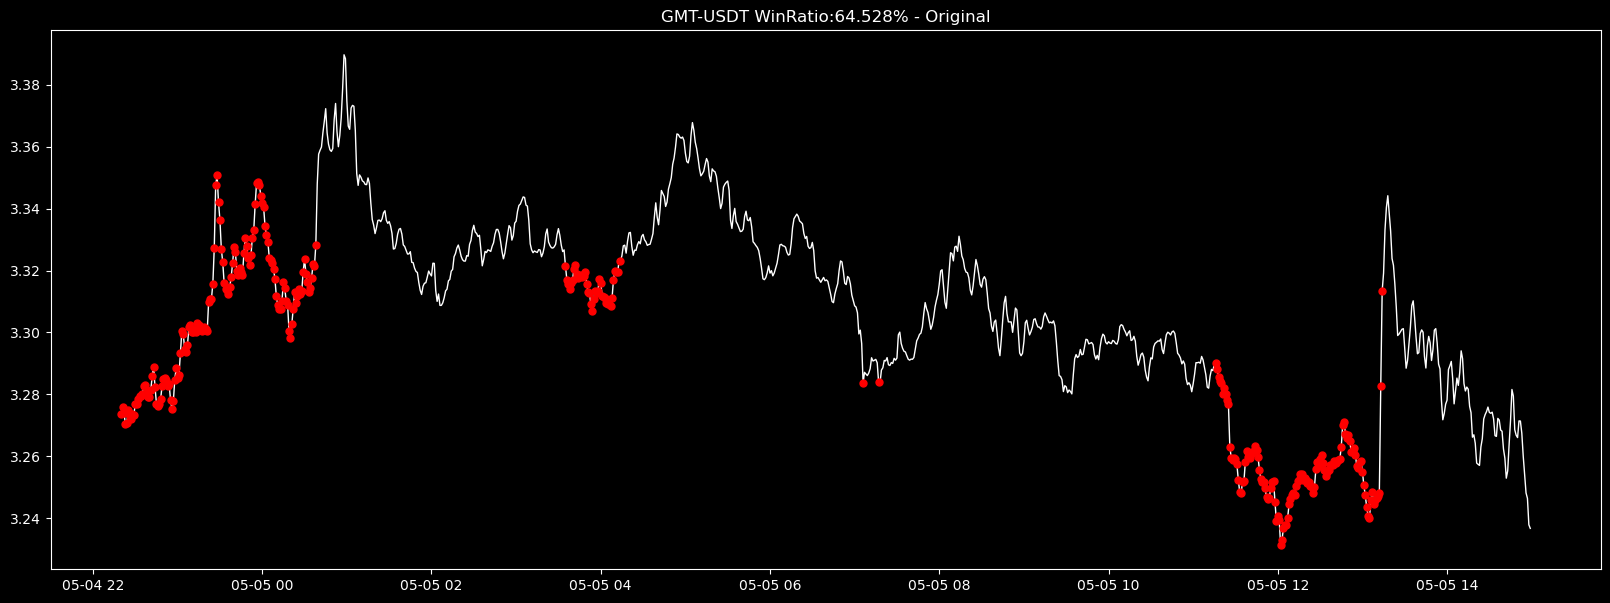

ValueError: in user code:

    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 1, 498), found shape=(None, 498)


In [ ]:
## Generate Data
BAD_PERIOD_START="2022-08-30"
BAD_PERIOD_END="2022-11-22"
pair_to_test="GMT/USDT"
MAX_FORCAST_SIZE=120
Model_FileName = "/UltimeTradingBot/Data/IS_CLOSE/tp310_w40_max40min_Model_minicnn.h5"
USED_MODEL=load_model(Model_FileName)

BUY_PCT_TEST=1.5
loc_start=0
loc_end=1000000


i_start=71900
i_end=i_start+200

# loc_start=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
# loc_end=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_END))

pair=pair_to_test
OnePair_DF=maxi_expand(pair=pair,i=loc_start,j=loc_end,window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=BUY_PCT_TEST,SELL_PCT=SELL_PCT,buy_function=is_high_win,
                           w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)

OnePair_DT=OnePair_DF.to_numpy()
gc.collect()
OnePair_DT=fixdt(OnePair_DT)
print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
hp(OnePair_DF.buy.mean(),"Buy mean pct")


plot_data("Original", pair_to_test, winratio, OnePair_DF, i_start, 1000, OnePair_DF.buy,dot_color="r",fig_width=20, fig_height=7)

OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
OnePair_Pred=OnePair_PredNote.round()

gc.collect()

Original_Traget_Data=OnePair_DT[:,-1]
Predicted_Data=OnePair_Pred[:,0]
gc.collect()
TruePred=(Original_Traget_Data==Predicted_Data).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
gc.collect()
TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
gc.collect()
LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
gc.collect()

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
gc.collect()

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
gc.collect()

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

print(f"========= Win Ratio:{winratio*100} %====================")




PREDICTION_TO_TEST=Predicted_Data



plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, 1000, PREDICTION_TO_TEST,dot_color="g",fig_width=20, fig_height=7)

In [ ]:
plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start+15000, 1000, PREDICTION_TO_TEST,dot_color="g",fig_width=20, fig_height=7)

In [ ]:
def plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, window_size, PREDICTION_TO_TEST, dot_color="g", fig_width=20, fig_height=5):
    i_end = i_start + window_size
    mname = Model_FileName.replace("/UltimeTradingBot/Data","")
    coin = pair_to_test.replace('/', '-')
    mtitle = f"{coin} WinRatio:{hp(winratio)}% - {mname}".replace("/", "-")

    x = np.linspace(0, 10, 500)
    dashes = []  # 10 points on, 5 off, 100 on, 5 off
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='price',c="w")
    line1.set_dashes(dashes)
    plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro',c=dot_color,markersize=5)
    plt.title(mtitle)

    plt.show()

# plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, 300, PREDICTION_TO_TEST,dot_color="g")






In [ ]:
XX=OnePair_DT[:100000,:-1]
YY=OnePair_DT[:100000,-1]
precision=0.0
# Good_Prediction_Note=very_deep_good_model.predict( XX)
# Bad_Prediction_Note=very_deep_bad_model.predict( XX)
# Initial_Pred_Note=model_init.predict( XX)
Predicted_Data=OnePair_Pred[:300000,0]
goodp=(Good_Prediction_Note-precision).round()
# badp=(Bad_Prediction_Note).round()
# initp=Initial_Pred_Note.round()

# Original_Traget_Data=YY

#Predicted_Data=((goodp==badp|initp==goodp))[:,0]
Predicted_Data=(goodp)[:,0]

GoodTruePred=(Original_Traget_Data==Predicted_Data).copy()
GoodModelAccuracy=hp(GoodTruePred.mean(),"ModelAccuracy")

GoodTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
GoodTrueWinPred_Mean=hp(GoodTrueWinPred.mean(),"True Win Predictions Mean of all")

GoodLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
GoodLossPred_Mean=hp(GoodLossPred.mean(),"XXX Loss Buy Mean of all")

GoodMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
GoodMissedDeal_Mean=hp(GoodMissedDealPred.mean(),"Missed good deal off all")

GoodGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodGoodZero_Mean=hp(GoodGoodZeroPred.mean(),"Good Zero prediction Mean")

winratio=GoodTrueWinPred_Mean/(GoodTrueWinPred_Mean+GoodLossPred_Mean)
fiability=GoodTrueWinPred_Mean + GoodLossPred_Mean + GoodMissedDeal_Mean + GoodGoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
print(f"========= Win Ratio:{winratio*100} ====================")


In [ ]:
def test_prediction(XX,YY,USEDMODEL)
XX=OnePair_DT[:100000,:-1]
YY=OnePair_DT[:100000,-1]

# Good_Prediction_Note=very_deep_good_model.predict( XX)
# Bad_Prediction_Note=very_deep_bad_model.predict( XX)
# Initial_Pred_Note=model_init.predict( XX)
goodp=(Good_Prediction_Note-precision).round()
# badp=(Bad_Prediction_Note).round()
# initp=Initial_Pred_Note.round()

# Original_Traget_Data=YY

#Predicted_Data=((goodp==badp|initp==goodp))[:,0]
Predicted_Data=(goodp)[:,0]

GoodTruePred=(Original_Traget_Data==Predicted_Data).copy()
GoodModelAccuracy=hp(GoodTruePred.mean(),"ModelAccuracy")

GoodTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
GoodTrueWinPred_Mean=hp(GoodTrueWinPred.mean(),"True Win Predictions Mean of all")

GoodLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
GoodLossPred_Mean=hp(GoodLossPred.mean(),"XXX Loss Buy Mean of all")

GoodMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
GoodMissedDeal_Mean=hp(GoodMissedDealPred.mean(),"Missed good deal off all")

GoodGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodGoodZero_Mean=hp(GoodGoodZeroPred.mean(),"Good Zero prediction Mean")

winratio=GoodTrueWinPred_Mean/(GoodTrueWinPred_Mean+GoodLossPred_Mean)
fiability=GoodTrueWinPred_Mean + GoodLossPred_Mean + GoodMissedDeal_Mean + GoodGoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
print(f"========= Win Ratio:{winratio*100} ====================")
